In [34]:
import netCDF4
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
# open netCDF file
run_name = 'os051qg'
url="http://geoport.whoi.edu/thredds/dodsC/usgs/data1/aretxabaleta/FLOC/gls_qcases/ocean_his_"\
+run_name+".nc"
#url = "D:\\crs\\src\\crs_public_data\\ocean_his.nc"

print "Opening ",url
nc = netCDF4.Dataset(url)

Opening  http://geoport.whoi.edu/thredds/dodsC/usgs/data1/aretxabaleta/FLOC/gls_qcases/ocean_his_os051qg.nc


In [20]:
# read vertical grid parameters
Vtransform = nc.variables['Vtransform'][:]
Vstretching = nc.variables['Vstretching'][:]
print 'Vtransform: ',Vtransform,' Vstretching: ',Vstretching
s_rho = nc.variables['s_rho'][:]
s_w = nc.variables['s_w'][:]
Cs_r = nc.variables['Cs_r'][:]
Cs_w = nc.variables['Cs_w'][:]
N = len(s_rho)
Np = len(s_w)
s= 'N  = len(s_rho): {0}, Np = len(s_w) : {1}\n'.format(len(s_rho),len(s_w))
print s
# print nc.variables['s_rho'] # get all the netCDF info
theta_s = nc.variables['theta_s'][:]
theta_b = nc.variables['theta_b'][:]
depth_c = nc.variables['hc'][:]

s = s+'hc = {0:f}\n'.format(depth_c)
print s

# here is the formula for calculating the depth parameter
a=theta_s
b=theta_b
sr = s_rho
C = (1.-b)*np.sinh(a*sr)/np.sinh(a) + b*(np.tanh(a*(sr+0.5))/(2.*np.tanh(0.5*a)) - 0.5)

# read water depth
i=3
j=4
h = nc.variables['h'][i,j]
hc = nc.variables['hc'][:]
zeta = nc.variables['zeta'][:,i,j]
s='Intial zeta: {0}, max. deviation: {1}\n'.format(zeta[0],max(abs(zeta-zeta[0])))
print s

Vtransform:  1  Vstretching:  1
N  = len(s_rho): 50, Np = len(s_w) : 51

N  = len(s_rho): 50, Np = len(s_w) : 51
hc = 0.000000

Intial zeta: 0.0, max. deviation: 7.12948536424e-14



In [21]:
# This is depths.py from the Octant module written by Rob Hetland
# encoding: utf-8
'''
Functions to calculate depths for an ocean model vertical s-coordinate

Define transformation functions for Vstretching and Vtransform for ocean vertical
s-coordinate.

Contains
--------

Vstretching:
    C = get_Vstretching_1(theta_s, theta_b)
    C = get_Vstretching_2(theta_s, theta_b)
    C = get_Vstretching_3(theta_s, theta_b, Hscale)
    C = get_Vstretching_4(theta_s, theta_b)
    C = get_Vstretching(Vstretching, theta_s, theta_b, Hscale=None)

Vtransform and depths:
    Zo = get_Vtransform_1(C, h, hc)
    Zo = get_Vtransform_2(C, h, hc)
    z = get_depths(Vtransform, C, h, hc)

S-coordinate:
    srho = get_srho(N)
    sw = get_sw(N)
    s = get_s(grid, N)

Wrapper functions:
    zw = get_zw(Vtransform, Vstretching, N, theta_s, theta_b, h, hc, zeta=0, Hscale=3)
    zrho = get_zrho(Vtransform, Vstretching, N, theta_s, theta_b, h, hc, zeta=0, Hscale=3)
    Hz = get_Hz(Vtransform, Vstretching, N, theta_s, theta_b, h, hc, zeta=0, Hscale=3)

Usage Examples
--------------

    >>> h = np.linspace(5, 50, 46)
    >>> hc = 20.0

    >>> C = get_Vstretching(4, theta_s=5.0, theta_b=2.0)
    >>> depths = get_depths(2, C, h, hc)
    >>> srho = get_srho(30)
    >>> zr = depths(srho)

    >>> C = get_Vstretching_3(theta_s=1.0, theta_b=1.0)
    >>> Zo = get_Vtransform_2(C, h, hc)
    >>> sw = get_sw(31)
    >>> Zo(sw)
    
    >>> Hz = get_Hz(1, 1, 30, theta_s=5.0, theta_b=0.5, h, hc)


See Also
--------

    octant.roms.nc_depths

'''
__docformat__ = "restructuredtext en"

import numpy as np


######################################################################
# Vstretching

def check_s_limits(Cwrapped):
    def C(s):
        assert np.alltrue( (s >= -1.0) & (s <= 0.0) ), \
            '-1.0 <= s <= 0.0 for valid Vstretching'
        return Cwrapped(s)
    return C


def get_Vstretching_1(theta_s, theta_b):
    '''
    Return C(s), the vertical coordinate stretching for Vstretching == 1
    
    C(s) = (1 - b) * [SINH(s * a) / SINH(a)] +
               b * [-0.5 + 0.5 * TANH(a * (s + 0.5)) / TANH(0.5 * a)]
    
    where the stretching parameters (a, b) are specify at input:
    
           a = theta_s               0 <  theta_s <= 8
           b = theta_b               0 <= theta_b <= 1
    
    If theta_b=0, the refinement is surface intensified as theta_s is increased.
    
    If theta_b=1, the refinement is both bottom and surface intensified
    as theta_s is increased.
    
    '''
    
    assert 0 <  theta_s <= 8, 'theta_s not in valid range for Vstretching == 1'
    assert 0 <= theta_b <= 1, 'theta_b not in valid range for Vstretching == 1'
    
    @check_s_limits
    def C(s):
        a = theta_s
        b = theta_b
        return (1 - b) * (np.sinh(s * a) / np.sinh(a)) + \
                b * (-0.5 + 0.5 * np.tanh(a * (s + 0.5)) / np.tanh(0.5 * a))
    
    C.__doc__ = get_Vstretching_1.__doc__
    C.__doc__ += '  -------------- Specified Parameters ----------\n'
    C.__doc__ += '  theta_s = %f\n' % theta_s
    C.__doc__ += '  theta_b = %f\n' % theta_b
    return C


def get_Vstretching_2(theta_s, theta_b):
    '''
    Return C(s), the vertical coordinate stretching for Vstretching == 2
    
    This vertical stretching function is defined, in the simplest form, as:
    
        C(s) = [1.0 - COSH(theta_s * s)] / [COSH(theta_s) - 1.0]
    
    it is similar in meaning to the original vertical stretcing function
    (Song and Haidvogel, 1994), but note that hyperbolic functions are
    COSH, and not SINH.
    
    Note that the above definition results in
           -1 <= C(s) <= 0
    as long as
           -1 <= s <= 0
    and, unlike in any previous definition
           d[C(s)]/ds  -->  0      if  s -->  0
    For the purpose of bottom boundary layer C(s) is further modified
    to allow near-bottom refinement.  This is done by blending it with
    another function.
    '''

    @check_s_limits
    def C(s):
        return (1.0 - np.cosh(theta_s * s)) / (np.cosh(theta_s) - 1.0)
    
    C.__doc__ = get_Vstretching_2.__doc__
    C.__doc__ += '  -------------- Specified Parameters ----------\n'
    C.__doc__ += '  theta_s = %f\n' % theta_s
    C.__doc__ += '  theta_b = %f\n' % theta_b
    return C


def get_Vstretching_3(theta_s, theta_b, Hscale=3.0):
    '''
    Return C(s), the vertical coordinate stretching for Vstretching == 3
    
    This stretching function is intended for very shallow coastal
    applications, like gravity sediment flows.
    
    At the surface, C(s=0)=0
    
        C(s) = - LOG(COSH(Hscale * ABS(s) ** alpha)) /
                 LOG(COSH(Hscale))
    
    At the bottom, C(s=-1)=-1
    
        C(s) = LOG(COSH(Hscale * (s + 1) ** beta)) /
               LOG(COSH(Hscale)) - 1
    
    where
    
         Hscale : scale value for all hyperbolic functions
                    Hscale = 3.0    set internally here
          alpha : surface stretching exponent
                    alpha = 0.65   minimal increase of surface resolution
                            1.0    significant amplification
           beta : bottoom stretching exponent
                    beta  = 0.58   no amplification
                            1.0    significant amplification
                            3.0    super-high bottom resolution
              s : stretched vertical coordinate, -1 <= s <= 0
    
    The stretching exponents (alpha, beta) are specified at input:
    
           alpha = theta_s
           beta  = theta_b
    
    '''
    
    assert 0.0 <  theta_s , 'theta_s must be positive for Vstretching == 3'
    assert 0.0 <= theta_b , 'theta_b must be positive for Vstretching == 3'
    
    @check_s_limits
    def C(s):
        exp_sur = theta_s
        exp_bot = theta_b
        
        Cbot = np.log(np.cosh(Hscale * (s + 1.0)**exp_bot))/np.log(np.cosh(Hscale)) - 1.0
        Csur = -np.log(np.cosh(Hscale * np.abs(s)**exp_sur))/np.log(np.cosh(Hscale))
        Cweight = 0.5 * (1.0 - np.tanh(Hscale * (s + 0.5)))
        
        return Cweight * Cbot + (1.0 - Cweight) * Csur
    
    C.__doc__ = get_Vstretching_3.__doc__
    C.__doc__ += '  -------------- Specified Parameters ----------\n'
    C.__doc__ += '  theta_s = %f\n' % theta_s
    C.__doc__ += '  theta_b = %f\n' % theta_b
    C.__doc__ += '  Hscale = %f\n' % Hscale
    return C


def get_Vstretching_4(theta_s, theta_b):
    '''
    Return C(s), the vertical coordinate stretching for Vstretching == 4
    
    The range of meaningful values for the control parameters are:
    
         0 <  theta_s <= 10.0
         0 <= theta_b <=  3.0
    
    Users need to pay attention to extreme r-factor (rx1) values near
    the bottom.
    
    This vertical stretching function is defined, in the simplest form, as:
    
        C(s) = [1.0 - COSH(theta_s * s)] / [COSH(theta_s) - 1.0]
    
    it is similar in meaning to the original vertical stretcing function
    (Song and Haidvogel, 1994), but note that hyperbolic functions are
    COSH, and not SINH.
    
    Note that the above definition results in -1 <= C(s) <= 0
    as long as -1 <= s <= 0 and
    
           d[C(s)]/ds  -->  0      if  s -->  0
    
    For the purpose of bottom boundary layer C(s) is further modified
    to allow near-bottom refinement by using a continuous, second
    stretching function
    
           C(s) = [EXP(theta_b * C(s)) - 1.0] / [1.0 - EXP(-theta_b)]
    
    This double transformation is continuous with respect to "theta_s"
    and "theta_b", as both values approach to zero.
    '''
    assert 0.0 <  theta_s <= 10.0, 'theta_s not in valid range for Vstretching == 4'
    assert 0.0 <= theta_b <= 3.0, 'theta_s not in valid range for Vstretching == 4'
    
    @check_s_limits
    def C(s):
        C = (1.0 - np.cosh(theta_s * s)) / (np.cosh(theta_s) - 1.0)
        return (np.exp(theta_b * C) - 1.0) / (1.0 - np.exp(-theta_b))
    
    C.__doc__ = get_Vstretching_3.__doc__
    C.__doc__ += '  -------------- Specified Parameters ----------\n'
    C.__doc__ += '  theta_s = %f\n' % theta_s
    C.__doc__ += '  theta_b = %f\n' % theta_b
    return C


def get_Vstretching(Vstretching, theta_s, theta_b, Hscale=3.0):
    '''
    Return the vertical stretching function C
    
    See also
    --------
    get_Vstretching_1(theta_s, theta_b)
    get_Vstretching_2(theta_s, theta_b)
    get_Vstretching_3(theta_s, theta_b, Hscale=3.0)
    get_Vstretching_4(theta_s, theta_b)
    '''    
    if Vstretching == 1:
        return get_Vstretching_1(theta_s, theta_b)
    elif Vstretching == 2:
        return get_Vstretching_2(theta_s, theta_b)
    elif Vstretching == 3:
        return get_Vstretching_3(theta_s, theta_b, Hscale)
    elif Vstretching == 4:
        return get_Vstretching_4(theta_s, theta_b)    
    else:
        raise Exception('Vstretching must be 1, 2, 3, or 4')

######################################################################
# Vtransform

def get_Vtransform_1(C, h, hc):
    '''
    return Zo(s, zeta=0) based on Vtransform == 1
    
    Original transformation (Shchepetkin and McWilliams, 2005): In 
    ROMS since 1999 (version 1.8):                                 
    
    Original formulation: Compute vertical depths (meters, negative) at
                          RHO- and W-points, and vertical grid
                          thicknesses. Various stretching functions are possible.
    
           depths(x,y,s,t) = Zo(x,y,s) + zeta(x,y,t) * [1 + Zo(x,y,s)/h(x,y)]
    
    where,
           Zo = hc * [s(k) - C(k)] + C(k) * h(x,y)
    or                                                            
           Zo(x,y,s) = hc * s + [h(x,y) - hc] * C(s)                    
    such that                                                              
           Zo(x,y,s) = 0         for s = 0,  C(s) = 0,  at the surface  
           Zo(x,y,s) = -h(x,y)   for s = -1, C(s) = -1, at the bottom   
    
    The size of h defines the horizontal dimensions of the depths.
    
    '''
    def Zo(s):
        if np.ndim(h) == 1:
            s = s[:, np.newaxis]
        if np.ndim(h) == 2:
            s = s[:, np.newaxis, np.newaxis]
        
        assert hc <= np.min(h), 'hc cannot be larger than the minimum depth'
        
        return hc * (s - C(s)) + C(s) * h
        
    Zo.__doc__ = 'Return Zo based on Vtransform == 1\n'
    Zo.__doc__ += get_Vtransform_1.__doc__[1:]
    return Zo


def get_Vtransform_2(C, h, hc):
    '''
    Return function Zo(s) based on Vtransform == 2
    
    New transformation: In UCLA-ROMS since 2005.
    New formulation: Compute vertical depths (meters, negative) at
                     RHO- and W-points, and vertical grid thicknesses.
    Various stretching functions are possible.
    
            depths(x,y,s,t) = zeta(x,y,t) + [zeta(x,y,t)+ h(x,y)] * Zo(x, y, s)
    
    where                                                          
            Zo = [hc * s(k) + C(k) * h(x,y)] / [hc + h(x,y)]                 
    or                                                                   
            Zo(x,y,s) = [hc * s(k) + h(x,y) * C(k)] / [hc + h(x,y)]      
    such that                                                             
            Zo(x,y,s) = 0         for s = 0,  C(s) = 0,  at the surface  
            Zo(x,y,s) = -1        for s = -1, C(s) = -1, at the bottom   
    
    The size of h defines the horizontal dimensions of the depths.
    
    '''
    
    def Zo(s):
        if np.ndim(h) == 1:
            s = s[:, np.newaxis]
        if np.ndim(h) == 2:
            s = s[:, np.newaxis, np.newaxis]
                    
        return (hc * s + C(s) * h) / (hc + h)
    
    Zo.__doc__ = 'Return Zo based on Vtransform == 2\n'
    Zo.__doc__ += get_Vtransform_2.__doc__[1:]
    return Zo
    
######################################################################
# Depths

def get_depths(Vtransform, C, h, hc):
    '''
    Return depths function associated with ocean model s-coordinate 
    
    Inputs
    ------
    
    Vtransform : integer
            Either 1 or 2, specifies the vertical transform equation
    C : function
            Function C(s) returns the vertical stretching.  
            Obtained with get_Vstretching()
    h : scalar, 1D, or 2D array
            The water depth(s) at which to calculate the depths
    hc : float
            The critical depth that defines regions of enhanced vertical resolution
    
    Output
    ------
    depths(s, zeta=0) : function
            A function that returns s-coordinate depths
    '''
    
    if Vtransform == 1:
        def depths(s, zeta=0):
            Zo = get_Vtransform_1(C, h, hc)
            return Zo(s) + zeta * (1 + Zo(s)/h)
            
        depths.__doc__ = 'Return depths(s, zeta=0) based on Vtransform == 1\n'
        depths.__doc__ += get_Vtransform_1.__doc__[1:]
        return depths
            
    elif Vtransform == 2:
        def depths(s, zeta=0):
            Zo = get_Vtransform_2(C, h, hc)
            return zeta + (zeta + h) * Zo(s)
            
        depths.__doc__ = 'Return depths(s, zeta=0) based on Vtransform == 2\n'
        depths.__doc__ += get_Vtransform_2.__doc__[1:]
        return depths
        

######################################################################
# S-coordinate
        
def get_sw(N):
    return np.linspace(-1.0, 0.0, N)


def get_srho(N):
    sr = np.linspace(-1.0, 0.0, N+1)
    return 0.5 * (sr[1:] + sr[:-1])


def get_s(grid, N):
    if grid == 'w':
        return get_sw(N)
    elif grid == 'rho':
        return get_srho(N)
    else:
        raise Exception("grid must be either 'w' or 'rho'.")


######################################################################
# Wrapper functions

def get_zw(Vtransform, Vstretching, N, theta_s, theta_b, h, hc, zeta=0, Hscale=3):
    sw = get_sw(N)
    C = get_Vstretching(Vstretching, theta_s, theta_b, Hscale)
    depths = get_depths(Vtransform, C, h, hc)
    return depths(sw, zeta)


def get_zrho(Vtransform, Vstretching, N, theta_s, theta_b, h, hc, zeta=0, Hscale=3):
    srho = get_srho(N)
    C = get_Vstretching(Vstretching, theta_s, theta_b, Hscale)
    depths = get_depths(Vtransform, C, h, hc)
    return depths(srho, zeta)
    
def get_Hz(Vtransform, Vstretching, N, theta_s, theta_b, h, hc, zeta=0, Hscale=3):
    sw = get_sw(N+1)
    C = get_Vstretching(Vstretching, theta_s, theta_b, Hscale)
    depths = get_depths(Vtransform, C, h, hc)
    return np.diff(depths(sw, zeta), axis=0)



# DESIGN QUESTIONS and TODO items

# should get_srho and get_sw take the same N (i.e., always return N values),
# or should both be based on N rho points, as in ROMS?

# is the check_s_limits decorator cool/flexible or confusing/distracting?

# Naming and variable input order in wrapper functions OK?

# Unit tests?  Would be nice.

# is there more or better logic that returns things of the right shape?  In particular, is
# there a way to ensure that zeta broadcasts correctly?  This is probably more important for
# nc_depths, when the depths object is indexed, but some of that logic could be brought
# over here.





In [29]:
# use Rob Hetland's depths.py functions
zw = get_zw(Vtransform=Vtransform, Vstretching=Vstretching, N=N+1, \
    theta_s=theta_s, theta_b=theta_b, h=h, hc=hc, zeta=0, Hscale=3)
zr = get_zrho(Vtransform=Vtransform, Vstretching=Vstretching, N=N, \
    theta_s=theta_s, theta_b=theta_b, h=h, hc=hc, zeta=0, Hscale=3)

time = nc.variables['ocean_time'][:]
nt = len(time)
nz = len(zr)
nzw = len(zw)
dz = np.diff(zw)
s = "nt, nz, nzw: {0}, {1}, {2}\n".format(nt,nz,nzw)
s = s+"Final time: {0} hrs.\n".format(time[-1]/3600.)
print s
dz2d = np.tile(dz,(nt,1))
print 'shape(dz2d) = ',np.shape( dz2d )
ubar = nc.variables['ubar'][:]
vbar = nc.variables['vbar'][:]
print 'shape(ubar), shape(vbar) =',np.shape(ubar),np.shape(vbar)
AKv = nc.variables['AKv'][:]
u = nc.variables['u'][:] 
bustr = nc.variables['bustr'][:]
rho = nc.variables['rho'][:]
print 'shape(u)',np.shape(u)
print 'len(s_rho)',len(s_rho)

print 'h=',h
zr = h+ zr[:]
zw = h+ zw[:]

 nt, nz, nzw: 73, 50, 51
Final time: 12.0 hrs.

shape(dz2d) =  (73L, 50L)
shape(ubar), shape(vbar) = (73L, 7L, 7L) (73L, 6L, 8L)
shape(u) (73L, 50L, 7L, 7L)
len(s_rho) 50
h= 12.0


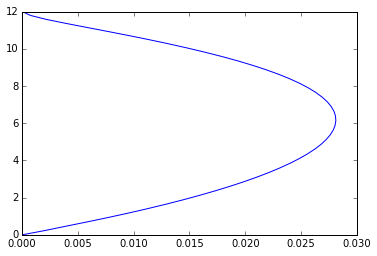

In [31]:
# vprofile - Make a profile at the end of the simulation
kappa=0.41
AKv = nc.variables['AKv'][-1,:,i,j]
# elevations for 
#zwcalc = zw[0] + concatenate(0, cumsum(diff(zr)));
#f = interp1d(zw,AKv)
#AKvi = f(zwcalc)
u = nc.variables['u'][-1,:,i,j]
v = nc.variables['v'][-1,:,i,j]
plt.plot(AKv,zw)

In [32]:
# this is only partially translated from Matlab
dudz = -np.diff(u)./np.diff(zr)
taub = bustr[-1,i,j]
taus = sustr[-1,i,j]
rhoav = np.mean(rho[:])+1000
tau = [taub; rhoav*AKvi[2:-1].*dudz; -taus]

dudzt = (taus/rhoav)./AKv;

ustr = np.sqrt(abs(taub)/rho0)
K = kappa*ustr*zw
K = kappa*ustr*zw.*(1-zw./h)
up = (ustr./kappa)*np.log(zu./Zob)
%
figure(1);clf
h3=plot([0;0],[log10(Zob);log10(Zob)],'ok')
set(h3,'markerfacecolor',[0 0 0],'markersize',6)
hold on
h1=plot(abs(u),log10(zu),'linewidth',2)
hold on
h2=plot([0;up],[log10(Zob);log10(zu)],'--k')
%h2=plot([up],[log10(zu)],'--k')
axis([-.001  max(up) -2.5 log10(max(zw))])

xlabel('Speed (m/s)')
ylabel('log_{10} [ z (m) ]')
s1 = '\itu'
s2 = '\itu_* / \kappa ln(\it{z/z_0})'
s3 = '\itz_{ob}'
legend([h1;h2;h3],s1,s2,s3,'location','southeast')
title('Log Profile')
%%
figure(2);clf
subplot(121)
plot(AKv,zw,'.')
hold on
hh1=plot(AKv,zw,'-b')
hh2=plot(K,zw,'--k')
ylabel(' z (m)')
xlabel('AKv (m^2/s)')
title('Eddy Viscosity and Reynolds Stress Profiles')
sa='Model {\itA_{Kv}}'
sb='{\itA_{Kv} = \kappa u_* z} ({\it1-z/h} )'
legend([hh1;hh2],sa,sb)
subplot(122)
plot(tau,zw,'.')
hold on
hh1=plot(tau,zw,'-b')
%plot([taub;0],[0; h],'--k')
plot([taub;-taus],[0; h],'--k')
xlabel('Stress (Pa)')
sa = '{\it\tau = \rho A_{Kv}} d{\itu}/d{\itz}'
legend(hh1,sa)
%%
dudzt = (taub*(1-zw./h)/rhoav)./AKv;
figure(3); clf
hr=plot(dudzt(2:end-1),zw(2:end-1),'-r','linewidth',2)
hold on
hm=plot(dudzt(2:end-1),zwcalc(2:end),'+k','linewidth',2)
hb=plot(dudz,zwcalc(2:end),'--b','linewidth',2)
sb = '\Deltau/\Deltaz_u'
sr = '\tau_b(1-\it{z_w / h})/(\rho \itA_{Kv})'
sm = '\tau_b(1-\it{z_{wcalc} / h})/(\rho \itA_{Kv})'
xlabel( '(s^{-1})')
ylabel('z (m)')
legend([hr;hm;hb],sr,sm,sb)
title('Shear Profile')
%%
figure(4); clf
plot(ocean_time./3600,squeeze(ubar(i,j,:)))
xlabel('Time (h)')
ylabel('Depth-Mean {\itu}-velocity (m/s)')
%%
figure(5); clf
plot(squeeze(mud_01(i,j,:,end)),zr)

SyntaxError: invalid syntax (<ipython-input-32-e56edda296f0>, line 2)